# Self-Calibrated Adversarial Uncertainty

In [678]:
#!g1.1
from scau import nets, data
from scau.data_processing import *
from scau.params import *
from scau.train import train, repeater, ParticleSet
from scau.eval import *
from matplotlib.pyplot import figure
from scau.eval import generate_df
from scau.rich_utils import model_testing
from scau.rich_utils.my_roc_auc import my_roc_auc
from sklearn.metrics import mean_squared_error, mean_absolute_error
from cloud_ml.storage.api import Storage

import os
import numpy as np
import torch
from tqdm import tqdm
import pandas as pd 
import torch 
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns

## Data Analysis

In [657]:
#!g1.1 
disk = Storage.ya_disk(application_id='66c6f9add43e46398507e9379843dfa2', application_secret='cbdfd644b4874156b6f33d4469257b5d')

files = [
    "kaon_-_down_2016_.csv",
    "kaon_-_up_2016_.csv",
    "kaon_+_down_2016_.csv",
    "kaon_+_up_2016_.csv",
    "kaon2_-_down_2016_.csv",
    "kaon2_-_up_2016_.csv",
    "kaon2_+_down_2016_.csv",
    "kaon2_+_up_2016_.csv",
    "muon_-_down_2016_.csv",
    "muon_-_up_2016_.csv",
    "muon_+_down_2016_.csv",
    "muon_+_up_2016_.csv",
    "pion_-_down_2016_.csv",
    "pion_-_up_2016_.csv",
    "pion_+_down_2016_.csv",
    "pion_+_up_2016_.csv",
    "pion2_-_down_2016_.csv",
    "pion2_-_up_2016_.csv",
    "pion2_+_down_2016_.csv",
    "pion2_+_up_2016_.csv",
    "proton_-_down_2016_.csv",
    "proton_-_up_2016_.csv",
    "proton_+_down_2016_.csv",
    "proton_+_up_2016_.csv",
    "bootstrap_line_test_results.pickle",
    "weight_reg_line_test_results.pickle",
    "mcdropout_random_split_results.pickle",
]

Open the following url to obtain confirmation code: https://oauth.yandex.ru/authorize?response_type=code&client_id=66c6f9add43e46398507e9379843dfa2&display=popup&force_confirm=yes


Enter the confirmation code:  1152737


/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:864: UserWarning: The following variables cannot be serialized: disk
  warnings.warn(message)


In [544]:
#!g1.1 
for file in files:
    disk.get(f'rich/{file}', f'/home/jupyter/mnt/datasets/rich/{file}')

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:864: UserWarning: The following variables cannot be serialized: disk
  warnings.warn(message)


In [4]:
#!g1.1 
data_dir = '/home/jupyter/mnt/datasets/rich'

def get_particle_dset(particle):
    return [os.path.join(data_dir, name) for name in os.listdir(data_dir) if particle in name]

datasets = {particle: get_particle_dset(particle) for particle in PARTICLES} 

In [623]:
#!g1.1 
_, _, _, data_train_s, data_val_s, data_test_s, scaler = data.get_val_dataset(datasets, PARTICLE_TYPE, dtype=np.float32, log=True)

Reading and concatenating datasets:
	/home/jupyter/mnt/datasets/rich/pion_-_down_2016_.csv
	/home/jupyter/mnt/datasets/rich/pion_-_up_2016_.csv
	/home/jupyter/mnt/datasets/rich/pion_+_down_2016_.csv
	/home/jupyter/mnt/datasets/rich/pion_+_up_2016_.csv
	/home/jupyter/mnt/datasets/rich/pion2_-_down_2016_.csv
	/home/jupyter/mnt/datasets/rich/pion2_-_up_2016_.csv
	/home/jupyter/mnt/datasets/rich/pion2_+_down_2016_.csv
	/home/jupyter/mnt/datasets/rich/pion2_+_up_2016_.csv
splitting to train/val/test
fitting the scaler
scaler train sample size: 2000000
scaler n_quantiles: 100000, time = 2.290261745452881
scaling train set
scaling val set
scaling val set
converting dtype to <class 'numpy.float32'>


In [624]:
#!g1.1
data_train_s.head()

RichDLLe  RichDLLk  RichDLLmu  RichDLLp  RichDLLbt  Brunel_P  Brunel_ETA  \
0  1.375198 -0.168807   0.840770 -0.895607  -0.993794  1.158502   -0.304906   
1  1.352173 -0.257850   1.300865 -0.965802  -0.792141  0.736548    0.511274   
2  0.932354  1.038101   0.608621  1.106748   1.048924 -1.022732    1.356118   
3  1.129330 -0.207799   0.943506 -1.059206  -1.291614  1.279240    0.536163   
4 -1.145713  0.290881  -1.509946  0.409991   0.387396 -1.189152   -1.285678   

   nTracks_Brunel  probe_sWeight  
0       -0.225130       1.204700  
1       -0.716156       1.083780  
2       -0.476938       0.665584  
3       -1.280037       0.581925  
4        0.454809       1.145070

In [627]:
#!g1.1 
N_VAL = int(3e5)
val_loader = repeater(torch.utils.data.DataLoader(ParticleSet(data_val_s),
                                                  batch_size=N_VAL,
                                                  shuffle=False,
                                                  pin_memory=True))

/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:864: UserWarning: The following variables cannot be serialized: val_loader
  warnings.warn(message)


In [628]:
#!g1.1 
rings = split_by_density_rings(data_val_s)
data_rings, rings_indices = rings

Computing intvals
Intvals computed


100%|██████████| 7/7 [01:20<00:00, 11.46s/it]


In [659]:
#!g1.1

import torch
import numpy as np
import os
import matplotlib.pyplot as plt
from itertools import repeat
from IPython.display import clear_output
from tqdm import tqdm_notebook, tqdm
from torch.autograd import Variable, grad

device = 'cuda' if torch.cuda.is_available() else 'cpu'


class ParticleSet(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = np.array(data)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, ind):
        return (
            self.data[ind, y_count:-1],  # X
            self.data[ind, -1],  # Weight
            self.data[ind, :y_count],  # DLL
        )


def repeater(data_loader):
    for loader in repeat(data_loader):
        for data in loader:
            yield data


def calc_gradient_penalty(netC, real_data, fake_data, fake_data2, batch_size=32):
    alpha = torch.rand(batch_size, 1)
    alpha = alpha.expand(real_data.size())
    alpha = alpha.to(device)

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    disc_interpolates = cramer_critic(netC, interpolates, fake_data2)

    gradients = grad(outputs=disc_interpolates, inputs=interpolates,
                     grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                     create_graph=True, retain_graph=True, only_inputs=True)[0]
    slopes = gradients.norm(2, dim=1)
    gradient_penalty = ((torch.max(torch.abs(slopes) - 1, torch.zeros_like(slopes))) ** 2).mean()
    return gradient_penalty


def cramer_critic(netC, x, y):
    discriminated_x = netC(x)
    return torch.norm(discriminated_x - netC(y), dim=1) - torch.norm(discriminated_x, dim=1)


def ensemble_penalty(netC, x, y):
    return torch.norm(netC(x) - netC(y), dim=1)


def get_set_predictions(x, netG):
    netG.eval()
    with torch.no_grad():
        generated = torch.cat([netG(x), x], dim=1)
    netG.train()

    return generated


def adversarial_loss(netC, netG, data):
    x, weight, dlls = data

    real_full_0 = torch.cat([dlls, x], dim=1)
    generated_1 = torch.cat([netG(x), x], dim=1)
    generated_2 = torch.cat([netG(x), x], dim=1)

    generator_loss = (cramer_critic(netC, real_full_0, generated_2) -
                      cramer_critic(netC, generated_1, generated_2)) * weight

    return real_full_0, generated_1, generated_2, generator_loss


def calculate_uncertainty_loss(netU, netC, netG, data):
    x, weight, dlls = data
    
    real_full_0 = torch.cat([dlls, x], dim=1)
    generated_1 = torch.cat([netG(x), x], dim=1)
    generated_2 = torch.cat([netG(x), x], dim=1)
    
    generator_loss = (cramer_critic(netC, real_full_0, generated_2) - 
                      cramer_critic(netC, generated_1, generated_2)) * weight
    
    uncertainty = netU(x)
    return torch.square(uncertainty - generator_loss)


def train_uncertainty_estimator_step(netU, netC, netG, netS, optU, data):
    optU.zero_grad()
    netC.eval()
    netG.eval()
    netU.train()
    
    x, weight, dlls = data
    
    weights = netS(x)
    _, uncertainty_weights = weights[:, 0], weights[:, 1]

    uncertainty = calculate_uncertainty_loss(netU, netC, netG, data) 
    uncertainty = torch.mean(uncertainty * uncertainty_weights)
    
    uncertainty.backward()
    optU.step()
    netU.eval()

    return uncertainty.item()


def train_separator_step(netS, netU, netC, netG, optS, data, reg_alpha):
    optS.zero_grad()
    netC.eval()
    netG.eval()
    netU.eval()
    netS.train()

    x, weight, dlls = data
    weights = netS(x)
    training_weights, uncertainty_weights = weights[:, 0], weights[:, 1]
    
    ### Regularisation part
    min_weights, _ = torch.min(weights, dim=1)
    alpha = reg_alpha * (16 * torch.square(min_weights) - 8 * min_weights + 1)
    ###
    
    _, _, _, adversarial = adversarial_loss(netC, netG, data)
    uncertainty = calculate_uncertainty_loss(netU, netC, netG, data) 
    total_loss = torch.mean(training_weights * uncertainty + uncertainty_weights * adversarial) + alpha
    
    if len(total_loss) > 0:
        total_loss = torch.mean(total_loss)

    total_loss.backward()
    optS.step()
    netS.eval()

    return total_loss.item()


def train_generator_step(netC, netG, optG, netS, data):
    optG.zero_grad()
    netC.eval()
    netS.eval()
    netG.train()
    
    x, weight, dlls = data

    weights = netS(x)
    training_weights, _ = weights[:, 0], weights[:, 1]
    _, _, _, generator_loss = adversarial_loss(netC, netG, data)
    assert(len(generator_loss) == len(training_weights))
    generator_loss = torch.mean(generator_loss * training_weights)

    generator_loss.backward()
    optG.step()

    return generator_loss.item()


def train_critic_step(netC, netG, optC, data, lambda_pt, iteration, batch_size):
    optC.zero_grad()
    netG.eval()
    netC.train()

    real_full_0, generated_1, generated_2, generator_loss = adversarial_loss(netC, netG, data)

    # GP
    gradient_penalty = calc_gradient_penalty(netC, real_full_0, generated_1, generated_2, batch_size)

    critic_loss = lambda_pt(iteration) * gradient_penalty - torch.mean(generator_loss)
    critic_loss.backward()
    optC.step()

    return critic_loss.item()


In [661]:
#!g1.1

models_path = data_dir + '/weights'
device = 'cuda'

netU = nets.UncertaintyEstimator().to(device)
netS = nets.Separator().to(device)
netC = nets.Critic().to(device)
netG = nets.Generator().to(device)

train(data_train_s, data_val_s, models_path, netG, netC, netU, netS, device, total_iter=1000)

# netU.load_state_dict(torch.load(models_path + '/uncertainty_estimator_weights.pt', map_location=torch.device(device))['model_state_dict'])
# netS.load_state_dict(torch.load(models_path + '/separator_weights.pt', map_location=torch.device(device))['model_state_dict'])
# netG.load_state_dict(torch.load(models_path + '/generators_without_weights.pt', map_location=torch.device(device))['model_state_dict'])

netU.eval()
netS.eval()
netG.eval()

<ipython-input-5-5eb0ac6e0025>:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(total_iter)):


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [08:09<00:00,  2.04it/s]


Generator(
  (layers): Sequential(
    (0): Linear(in_features=67, out_features=128, bias=True)
    (1): ReLU()
    (2): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.05)
    )
    (3): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.05)
    )
    (4): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.05)
    )
    (5): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.05)
    )
    (6): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.05)
    )
    (7): Linear(in_features=128, out_features=5, bias=True)
  )
)

## Rings experiment


### Preparing data

In [633]:
#!g1.1
rings_loaders = []
samples_num = np.inf
for ring in list(data_rings):
    data = pd.DataFrame(data=ring, columns=['RichDLLe', 'RichDLLk', 'RichDLLmu', 'RichDLLp', 'RichDLLbt', 'Brunel_P', 'Brunel_ETA', 'nTracks_Brunel', 'probe_sWeight'])
    data_loader = repeater(torch.utils.data.DataLoader(ParticleSet(data),
                                                      batch_size=data.shape[0],
                                                      shuffle=False,
                                                      pin_memory=True))
    rings_loaders.append(data_loader)
    print(ring.shape)
    samples_num = min(samples_num, ring.shape[0])
print('min shape:', samples_num)

(150235, 9)
(150203, 9)
(150049, 9)
(150071, 9)
(150064, 9)
(150004, 9)
(99372, 9)
min shape: 99372


/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:864: UserWarning: The following variables cannot be serialized: data_loader, rings_loaders
  warnings.warn(message)


### Computing metrics

In [635]:
#!g1.1 
device = 'cuda'
accs = []
uncs = []

for ring in rings_loaders:
    x, _, dlls = [i.to(device) for i in next(ring)]
    samples_num = x.shape[0]
    acc = 0
    acc = count_model_accuracy(x, scaler, dlls, netG, eval_model_by_classifier, samples_num) 
    unc = get_uncertainty(x, netU)
    weights = netS(x)
    accs.append(acc)
    uncs.append(unc.cpu().detach().numpy())

/home/jupyter/work/resources/scau/eval.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[:samples_num]).cpu()
/home/jupyter/work/resources/scau/eval.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
 33%|███▎      | 1/3 [00:04<00:09,  4.54s/it]/usr/local/lib/python3.8/dist-packages/xgboost/cor

In [636]:
#!g1.1
uncs

[array([[0.06873755],
        [0.06984498],
        [0.06962214],
        ...,
        [0.06853826],
        [0.06969627],
        [0.06887712]], dtype=float32),
 array([[0.06854123],
        [0.06943179],
        [0.06835319],
        ...,
        [0.06865856],
        [0.06751493],
        [0.07156684]], dtype=float32),
 array([[0.06968075],
        [0.06976289],
        [0.06892236],
        ...,
        [0.06823152],
        [0.06823166],
        [0.06921811]], dtype=float32),
 array([[0.06953435],
        [0.06823835],
        [0.06864265],
        ...,
        [0.06907634],
        [0.06829359],
        [0.06998061]], dtype=float32),
 array([[0.06979045],
        [0.06808702],
        [0.06943772],
        ...,
        [0.06850035],
        [0.06823522],
        [0.0700946 ]], dtype=float32),
 array([[0.06941347],
        [0.06956235],
        [0.06965021],
        ...,
        [0.06916969],
        [0.06860915],
        [0.06932262]], dtype=float32),
 array([[0.07035702],
      

### Drawing plots

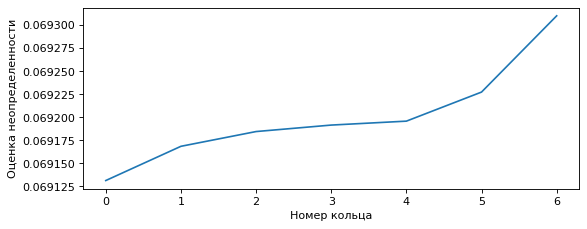

In [637]:
#!g1.1
figure(figsize=(8, 3), dpi=80)
plt.plot([np.array(u).mean() for u in uncs])
plt.xlabel('Номер кольца')
plt.ylabel('Оценка неопределенности')
plt.show()

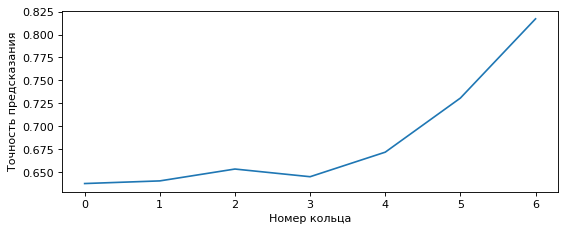

In [638]:
#!g1.1
figure(figsize=(8, 3), dpi=80)

plt.plot([np.array(u).mean() for u in accs])
plt.xlabel('Номер кольца')
plt.ylabel('Точность предсказания')
plt.show()

In [639]:
#!g1.1
# Normalise

r_min = 10000
r_max = -1
l_min = 10000
l_max = -1

for i in range(7):
    r_min = min(r_min, np.min(uncs[i]))
    r_max = max(r_max, np.max(uncs[i]))
    l_min = min(l_min, np.min(accs[i]))
    l_max = max(l_max, np.max(accs[i]))

normalised_uncs = np.copy(uncs)

def norm_unc(value):
    return (value - r_min) / (r_max - r_min) * (l_max - l_min) + l_min

for i in range(7):
    for j in range(len(uncs[i])):
        normalised_uncs[i][j] = norm_unc(normalised_uncs[i][j])

/kernel/fallback/lib/python3.8/site-packages/numpy/lib/function_base.py:792: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, order=order, subok=subok, copy=True)


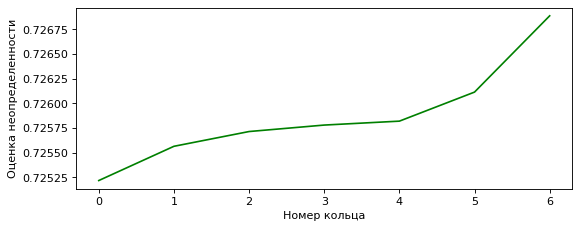

In [640]:
#!g1.1
figure(figsize=(8, 3), dpi=80)
plt.plot([np.array(u).mean() for u in uncs], c='g')
plt.xlabel('Номер кольца')
plt.ylabel('Оценка неопределенности')
plt.show()

## Lines experiment

### Data preparation

In [641]:
#!g1.1
def split_by_line(df, slope=1, intercept=0):
    top_half = df[df['Brunel_ETA'] > df['Brunel_P'] * slope + intercept]
    bottom_half = df[df['Brunel_ETA'] <= df['Brunel_P'] * slope + intercept]

    top_half = top_half.reset_index(drop=True)
    bottom_half = bottom_half.reset_index(drop=True)

    return top_half, bottom_half

def parse_dataset_np(data, r):
    targets = data.iloc[:, :5].to_numpy()
    features = data.iloc[:, -4:-1].to_numpy()
    weight = data.iloc[:, -1].to_numpy()

    return features[r], targets[r], weight[r]

In [329]:
#!g1.1
feats_train, targets_train, _ = parse_dataset_np(data_train_s)
feats_val, targets_val, _ = parse_dataset_np(data_val_s)

feats_train.shape, targets_train.shape, feats_val.shape, targets_val.shape

((2000000, 3), (2000000, 5), (1000000, 3), (1000000, 5))

In [374]:
#!g1.1
l_train, r_train = split_by_line(data_train_s)

r = np.random.choice(list(range(r_train.shape[0])), size=50000)
l = np.random.choice(list(range(l_train.shape[0])), size=50000)
r_feats_val, r_targets_val, _ = parse_dataset_np(r_train, r)
r_bands = split_by_bands(r_feats_val, r_targets_val, 10000)
l_feats_val, l_targets_val, _ = parse_dataset_np(l_train, l)
l_bands = split_by_bands(l_feats_val, l_targets_val, 10000)

bands = l_bands[::-1] + r_bands[:]

In [655]:
#!g1.1
for band in bands:
    print(len(band[0]))

10000
10000
10000
10000
10000
10000
10000
10000
10000
10000


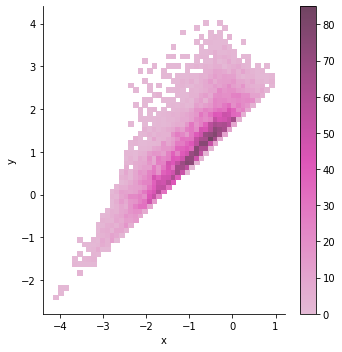

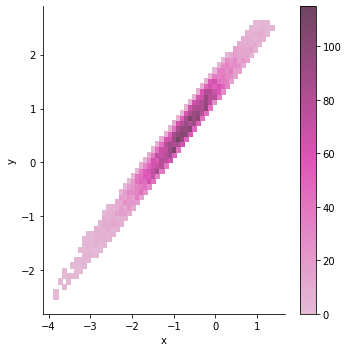

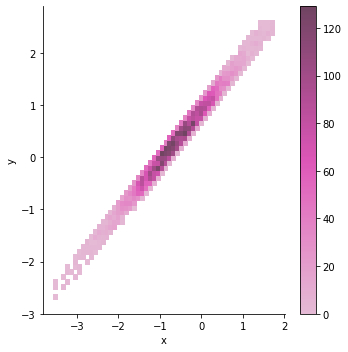

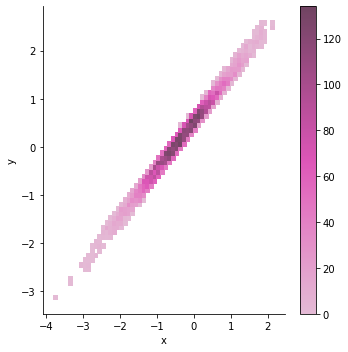

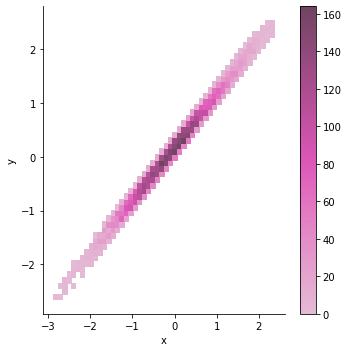

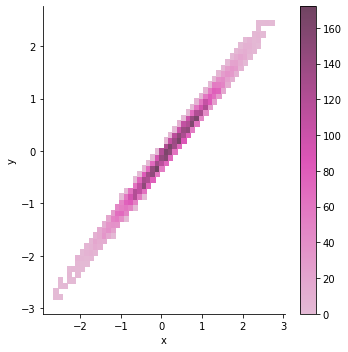

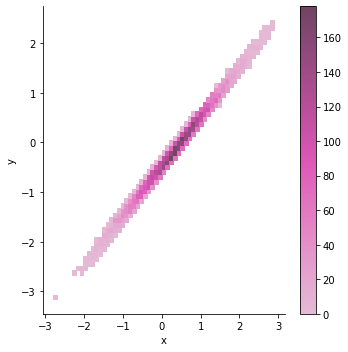

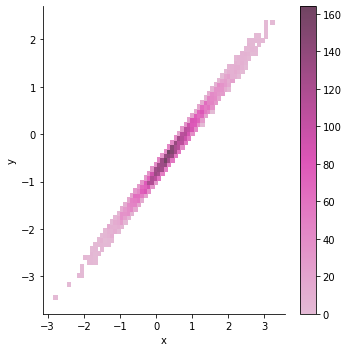

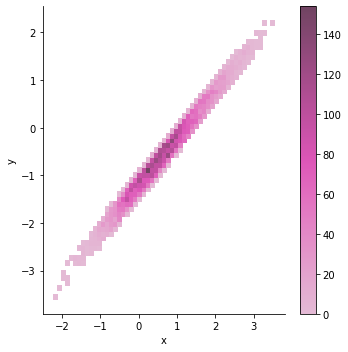

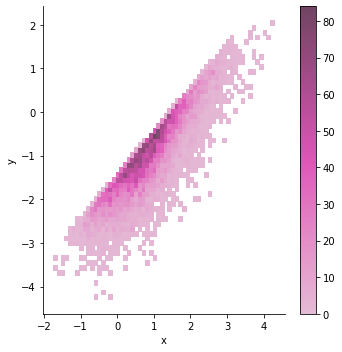

In [616]:
#!g1.1
    
for i, band in enumerate(bands):
    feats, target = band
    hist_df = pd.DataFrame(feats[:,:2], columns=['x', 'y'])
    sns.displot(hist_df, x='x', y='y', cbar=True, color='tab:pink')
    plt.savefig(f'{i}.jpg')
    plt.show()

In [645]:
#!g1.1
band_single_preds = [compute_scau_prediction(band[0]) for band in bands]

### Loading other methods metrics

In [546]:
#!g1.1
import pickle

with open("/home/jupyter/mnt/datasets/rich/bootstrap_line_test_results.pickle", "rb") as tf:
    bootstrap_line_test_results = pickle.load(tf)
    
with open("/home/jupyter/mnt/datasets/rich/weight_reg_line_test_results.pickle", "rb") as tf:
    weights_reg_line_test_results = pickle.load(tf)
    
with open("/home/jupyter/mnt/datasets/rich/mcdropout_random_split_results.pickle", "rb") as tf:
    mcdropout = pickle.load(tf)

In [528]:
#!g1.1
bootstrap_line_test_results['particle_0']
# ['data_efficiency']
# ['ensemble_efficiencies'][0]
# ['eff_low']
# ['eff_high']

{'x': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 'efficiency': [0.9965952686990394,
  0.9682388610339786,
  0.9017730113719988,
  0.8642326599095342,
  0.851859846738032,
  0.8555589352119862,
  0.8750453800641699,
  0.8865449336224575,
  0.881511425964265,
  0.8908327364423992],
 'ensemble_efficiencies': [[0.9970269925527635,
   0.9720164447540646,
   0.9120657005210122,
   0.8729946917589804,
   0.8540184660066524,
   0.854695487504538,
   0.8660674862878617,
   0.8696978914214508,
   0.8542637636508139,
   0.8516930443400021],
  [0.9971937949507933,
   0.9670908680593031,
   0.9003110374127967,
   0.8615343858237585,
   0.8512220728632123,
   0.8537731683624911,
   0.8708164486788269,
   0.8810012068644093,
   0.8786855971035255,
   0.8903421411540764],
  [0.9967326353797699,
   0.969190615893325,
   0.9164712462101514,
   0.8876831146913665,
   0.8735834061049678,
   0.8781557541921368,
   0.8919807294170746,
   0.9007623850780537,
   0.8977893776308172,
   0.9079937596279325],
  [0.9

### Drawing plots
#### 1. SCAU

Intersection of efficiency and uncertainty region for particle_0: 70.0%
Intersection of efficiency and uncertainty region for particle_1: 90.0%
Intersection of efficiency and uncertainty region for particle_2: 90.0%
Intersection of efficiency and uncertainty region for particle_3: 10.0%
Intersection of efficiency and uncertainty region for particle_4: 60.0%


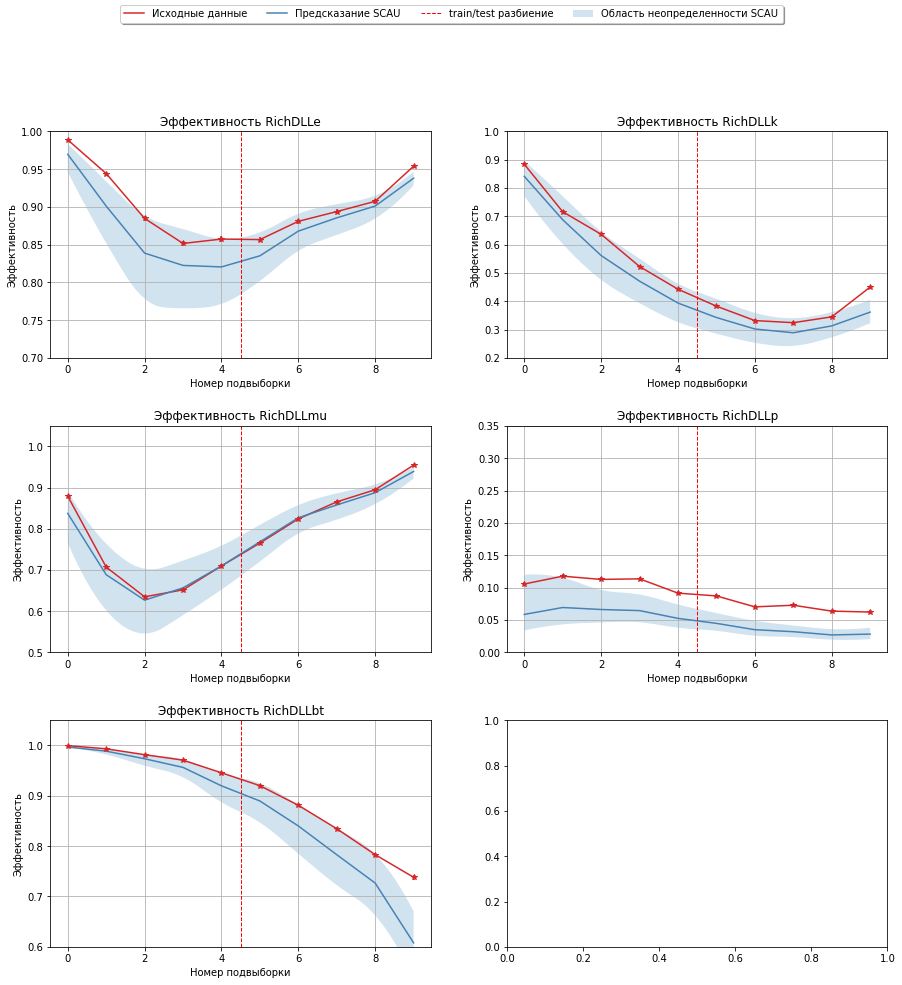

In [677]:
#!g1.1
dll_columns = ['RichDLLe', 'RichDLLk', 'RichDLLmu', 'RichDLLp', 'RichDLLbt']

fig, axes = plt.subplots(3, 2, figsize=(15, 15))
plt.subplots_adjust(hspace = .3)

band_feats = list(map(lambda x: x[0], bands))
band_targets = list(map(lambda x: x[1], bands))

results = {
    'band_feats': band_feats,
    'band_targets': band_targets
}

# Computed in the `DLL thresholds.ipynb`
pion_thresholds = [-1.281555, 0.007320, -0.813343, 1.345486, -1.281565]
y_lims = [[0.7, 1], [0.2, 1], [0.5, 1.05], [0, 0.35], [0.6, 1.05]]

for idx, ax in zip((0, 1, 2, 3, 4), axes.flatten()):
    threshold = threshold_selection(targets_train[:, idx])
    threshold = pion_thresholds[idx]
    
    particle_name = f'particle_{idx}'

    x, efficiency, eff_low, eff_high, errors = efficiency_bands_with_uncertainty(band_single_preds, 
                                                                                 band_feats, 
                                                                                 netU,
                                                                                 threshold, 
                                                                                 idx)

    x, eff, err = efficiency_bands(band_targets, threshold, idx)

    results[particle_name] = {
        'x': x,
        'efficiency': efficiency,
        'eff_low': eff_low,
        'eff_high': eff_high,
        'data_efficiency': eff
    }

    ax.errorbar(x, eff, err, fmt='*', color='tab:red')
    ax.plot(x, eff, label='Исходные данные', color='tab:red')
    
    # Computing intersection of the efficiencies and uncertainty region
    counter = 0.0
    for e_idx in range(len(eff)):
        e = eff[e_idx]
        if e <= eff_low[e_idx] and e >= eff_high[e_idx]:
            counter += 1
    print(f'Intersection of efficiency and uncertainty region for {particle_name}: {counter / 10 * 100}%')
    #

    ax.plot (x, efficiency, '-', color='steelblue', label='Предсказание SCAU')

    x_fill, eff_high_fill = smoothen_values(x, eff_high)
    x_fill, eff_low_fill = smoothen_values(x, eff_low)
    ax.fill_between(x_fill, eff_high_fill, eff_low_fill, alpha=0.2, label='Область неопределенности SCAU')


    y_low = min(eff_high) - 0.05

    ax.axvline(num_train_bands - 0.5, color='red', linestyle='--', linewidth=1, 
               label='train/test разбиение')

    ax.set_title (f"Эффективность {dll_columns[idx]}")
    ax.set_xlabel("Номер подвыборки")
    ax.set_ylabel("Эффективность")
    ax.set_ylim(y_low, 1.05)
    ax.set_ylim(y_lims[idx][0], y_lims[idx][1])
    ax.grid()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', fancybox=True, shadow=True, ncol=5)

plt.show()
fig.savefig('efficiency.jpg')

#### 2. 

Intersection of efficiency and uncertainty region for particle_0: 80.0%
Intersection of efficiency and uncertainty region for particle_1: 50.0%
Intersection of efficiency and uncertainty region for particle_2: 70.0%
Intersection of efficiency and uncertainty region for particle_3: 40.0%
Intersection of efficiency and uncertainty region for particle_4: 90.0%


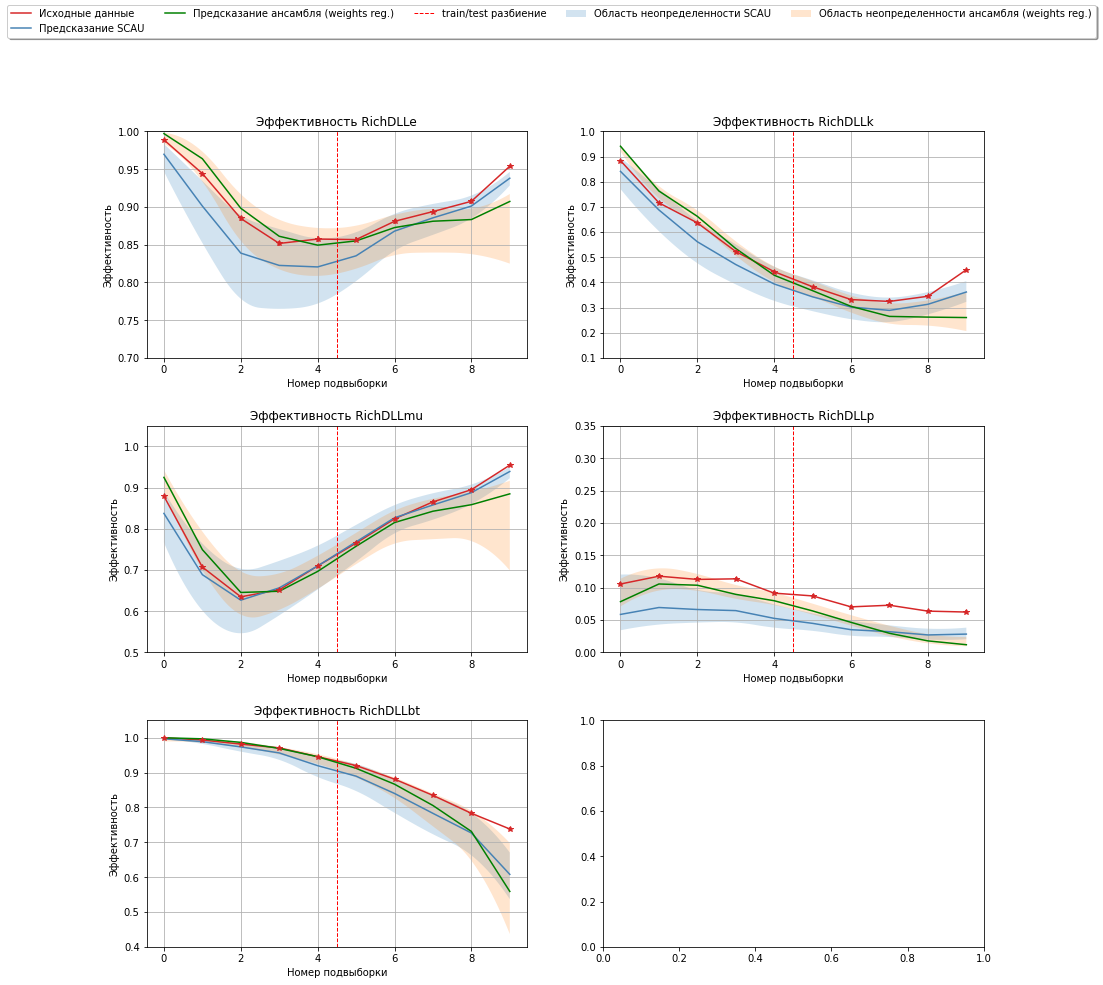

In [676]:
#!g1.1
dll_columns = ['RichDLLe', 'RichDLLk', 'RichDLLmu', 'RichDLLp', 'RichDLLbt']

fig, axes = plt.subplots(3, 2, figsize=(15, 15))
plt.subplots_adjust(hspace = .3)

band_feats = list(map(lambda x: x[0], bands))
band_targets = list(map(lambda x: x[1], bands))

results = {
    'band_feats': band_feats,
    'band_targets': band_targets
}

# Computed in the `DLL thresholds.ipynb`
pion_thresholds = [-1.281555, 0.007320, -0.813343, 1.345486, -1.281565]
y_lims = [[0.7, 1], [0.1, 1], [0.5, 1.05], [0, 0.35], [0.4, 1.05]]

for idx, ax in zip((0, 1, 2, 3, 4), axes.flatten()):
    threshold = threshold_selection(targets_train[:, idx])
    threshold = pion_thresholds[idx]
    
    particle_name = f'particle_{idx}'

    x, efficiency, eff_low, eff_high, errors = efficiency_bands_with_uncertainty(band_single_preds, 
                                                                                 band_feats, 
                                                                                 netU,
                                                                                 threshold, 
                                                                                 idx)

    x, eff, err = efficiency_bands(band_targets, threshold, idx)

    results[particle_name] = {
        'x': x,
        'efficiency': efficiency,
        'eff_low': eff_low,
        'eff_high': eff_high,
        'data_efficiency': eff
    }

    ax.errorbar(x, eff, err, fmt='*', color='tab:red')
    ax.plot(x, eff, label='Исходные данные', color='tab:red')
    
    weights_reg = weights_reg_line_test_results[particle_name]
    
    # Computing intersection of the efficiencies and uncertainty region
    counter = 0.0
    for e_idx in range(len(eff)):
        e = eff[e_idx]
        if e <= weights_reg['eff_low'][e_idx] and e >= weights_reg['eff_high'][e_idx]:
            counter += 1
    print(f'Intersection of efficiency and uncertainty region for {particle_name}: {counter / 10 * 100}%')
    #

    ax.plot (x, efficiency, '-', color='steelblue', label='Предсказание SCAU')
    ax.plot (x, weights_reg['efficiency'], '-', color='green', label='Предсказание ансамбля (weights reg.)')

    x_fill, eff_high_fill = smoothen_values(x, eff_high)
    x_fill, eff_low_fill = smoothen_values(x, eff_low)
    ax.fill_between(x_fill, eff_high_fill, eff_low_fill, alpha=0.2, label='Область неопределенности SCAU')
 
    x_fill, eff_high_fill = smoothen_values(x, weights_reg['eff_high'])
    x_fill, eff_low_fill = smoothen_values(x, weights_reg['eff_low'])
    ax.fill_between(x_fill, eff_high_fill, eff_low_fill, alpha=0.2, label='Область неопределенности ансамбля (weights reg.)')

    y_low = min(eff_high) - 0.05

    ax.axvline(num_train_bands - 0.5, color='red', linestyle='--', linewidth=1, 
               label='train/test разбиение')

    ax.set_title (f"Эффективность {dll_columns[idx]}")
    ax.set_xlabel("Номер подвыборки")
    ax.set_ylabel("Эффективность")
    ax.set_ylim(y_low, 1.05)
    ax.set_ylim(y_lims[idx][0], y_lims[idx][1])
    ax.grid()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', fancybox=True, shadow=True, ncol=5)

plt.show()
fig.savefig('efficiency_comparison_4.jpg')

Intersection of efficiency and uncertainty region for particle_0: 20.0%
Intersection of efficiency and uncertainty region for particle_1: 20.0%
Intersection of efficiency and uncertainty region for particle_2: 20.0%
Intersection of efficiency and uncertainty region for particle_3: 0.0%
Intersection of efficiency and uncertainty region for particle_4: 50.0%


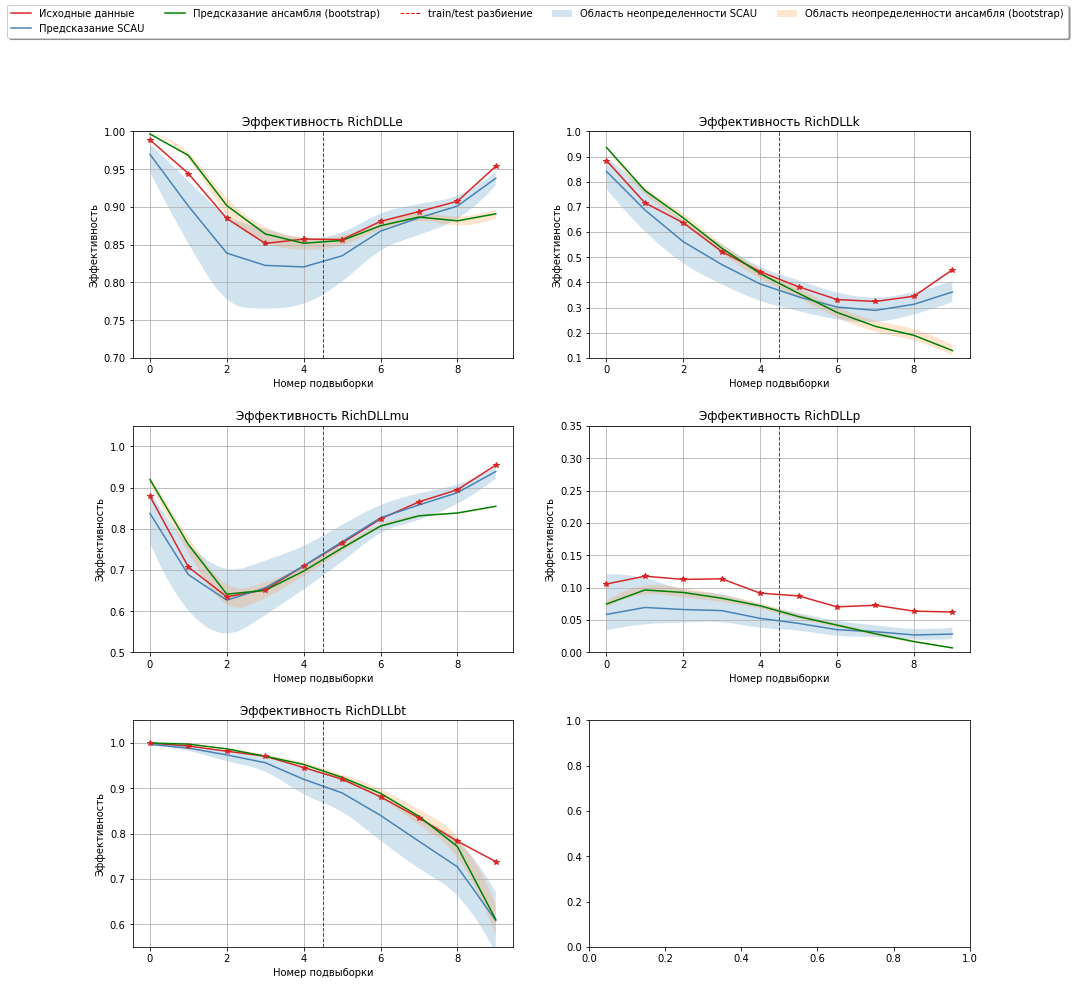

In [675]:
#!g1.1
dll_columns = ['RichDLLe', 'RichDLLk', 'RichDLLmu', 'RichDLLp', 'RichDLLbt']

fig, axes = plt.subplots(3, 2, figsize=(15, 15))
plt.subplots_adjust(hspace = .3)

band_feats = list(map(lambda x: x[0], bands))
band_targets = list(map(lambda x: x[1], bands))

results = {
    'band_feats': band_feats,
    'band_targets': band_targets
}

# Computed in the `DLL thresholds.ipynb`
pion_thresholds = [-1.281555, 0.007320, -0.813343, 1.345486, -1.281565]
y_lims = [[0.7, 1], [0.1, 1], [0.5, 1.05], [0, 0.35], [0.55, 1.05]]

for idx, ax in zip((0, 1, 2, 3, 4), axes.flatten()):
    threshold = threshold_selection(targets_train[:, idx])
    threshold = pion_thresholds[idx]
    
    particle_name = f'particle_{idx}'

    x, efficiency, eff_low, eff_high, errors = efficiency_bands_with_uncertainty(band_single_preds, 
                                                                                 band_feats, 
                                                                                 netU,
                                                                                 threshold, 
                                                                                 idx)

    x, eff, err = efficiency_bands(band_targets, threshold, idx)

    results[particle_name] = {
        'x': x,
        'efficiency': efficiency,
        'eff_low': eff_low,
        'eff_high': eff_high,
        'data_efficiency': eff
    }

    ax.errorbar(x, eff, err, fmt='*', color='tab:red')
    ax.plot(x, eff, label='Исходные данные', color='tab:red')
    
    bootstrap = bootstrap_line_test_results[particle_name]
    
    # Computing intersection of the efficiencies and uncertainty region
    counter = 0.0
    for e_idx in range(len(eff)):
        e = eff[e_idx]
        if e <= bootstrap['eff_low'][e_idx] and e >= bootstrap['eff_high'][e_idx]:
            counter += 1
    print(f'Intersection of efficiency and uncertainty region for {particle_name}: {counter / 10 * 100}%')
    #

    ax.plot (x, efficiency, '-', color='steelblue', label='Предсказание SCAU')
    ax.plot (x, bootstrap['efficiency'], '-', color='green', label='Предсказание ансамбля (bootstrap)')

    x_fill, eff_high_fill = smoothen_values(x, eff_high)
    x_fill, eff_low_fill = smoothen_values(x, eff_low)
    ax.fill_between(x_fill, eff_high_fill, eff_low_fill, alpha=0.2, label='Область неопределенности SCAU')
 
    x_fill, eff_high_fill = smoothen_values(x, bootstrap['eff_high'])
    x_fill, eff_low_fill = smoothen_values(x, bootstrap['eff_low'])
    ax.fill_between(x_fill, eff_high_fill, eff_low_fill, alpha=0.2, label='Область неопределенности ансамбля (bootstrap)')
    
    y_low = min(eff_high) - 0.05

    ax.axvline(num_train_bands - 0.5, color='red', linestyle='--', linewidth=1, 
               label='train/test разбиение')

    ax.set_title (f"Эффективность {dll_columns[idx]}")
    ax.set_xlabel("Номер подвыборки")
    ax.set_ylabel("Эффективность")
    ax.set_ylim(y_low, 1.05)
    ax.set_ylim(y_lims[idx][0], y_lims[idx][1])
    ax.grid()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', fancybox=True, shadow=True, ncol=5)

plt.show()
fig.savefig('efficiency_comparison_5.jpg')

In [411]:
#!g1.1


In [412]:
#!g1.1
plt.rcdefaults()

In [451]:
#!g1.1
import pandas as pd


c1 = (89., 89., 89.)
c2 = (255.,128.,14.)
c3= (0.,107.,164.,)
c4=(162.,200.,236.)
c5=(255.,188.,121.)
c6 = (200.,82.,0.)

colors= [c1, c2, c3, c4, c5, c6]

for i in range(6):
    colors[i] = tuple([ci/255 for ci in colors[i]])
    
#import seaborn as sns
hist_dfs = [None] * len(bands)
for i, band in enumerate(bands):
    feats, ts = band
    d = np.concatenate([ts, feats], axis=1)
    d = scaler.inverse_transform(d)[:,5:7]
    d[:, 0] /= 1000
    hist_df = pd.DataFrame(d, columns=['Momentum (GeV/c)', 'Pseudorapidity'])
    hist_df['labels'] = 'train data' if i < 5 else f'test band #{i}'
    hist_dfs[i] = hist_df
    
result = pd.concat(hist_dfs)
plt.subplots_adjust(hspace = .3)
clrs1 = list(sns.color_palette("bright", 10))
new_clrs = [clrs1[7], clrs1[4],clrs1[8], clrs1[2], clrs1[8],  clrs1[0]]
d = result
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
newcmps = []
for c in colors:
    N = 256
    vals = np.ones((N, 4))
    vals[:, 0] = np.linspace(max(0, c[0]-0.1),min(c[0]+0.1, 1), N)
    vals[:, 1] = np.linspace(max(0, c[1]-0.1),min(c[1]+0.1, 1), N)
    vals[:, 2] = np.linspace(max(0, c[2]-0.1),min(c[2]+0.1, 1), N)
    newcmp = ListedColormap(vals)
    newcmps.append(newcmp)

<Figure size 432x288 with 0 Axes>

<Figure size 4000x3200 with 0 Axes>

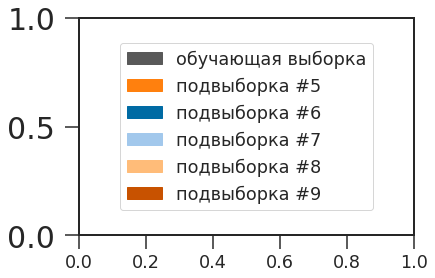

In [465]:
#!g1.1
figure(figsize=(10, 8), dpi=400)
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
labels = ['обучающая выборка', 'подвыборка #5', 'подвыборка #6', 'подвыборка #7', 'подвыборка #8', 'подвыборка #9']
legend_elements = [
                   Patch(facecolor=colors[i], edgecolor=colors[i],
                         label=labels[i]) for i in range(6)]

# Create the figure
fig, ax = plt.subplots()
ax.legend(handles=legend_elements, loc='center')

plt.show()

<ipython-input-23-ba62078a932b>:41: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('log extrapolation illustration.png', format='png', bbox=True, bbox_inches='tight', pad_inches=0.1)


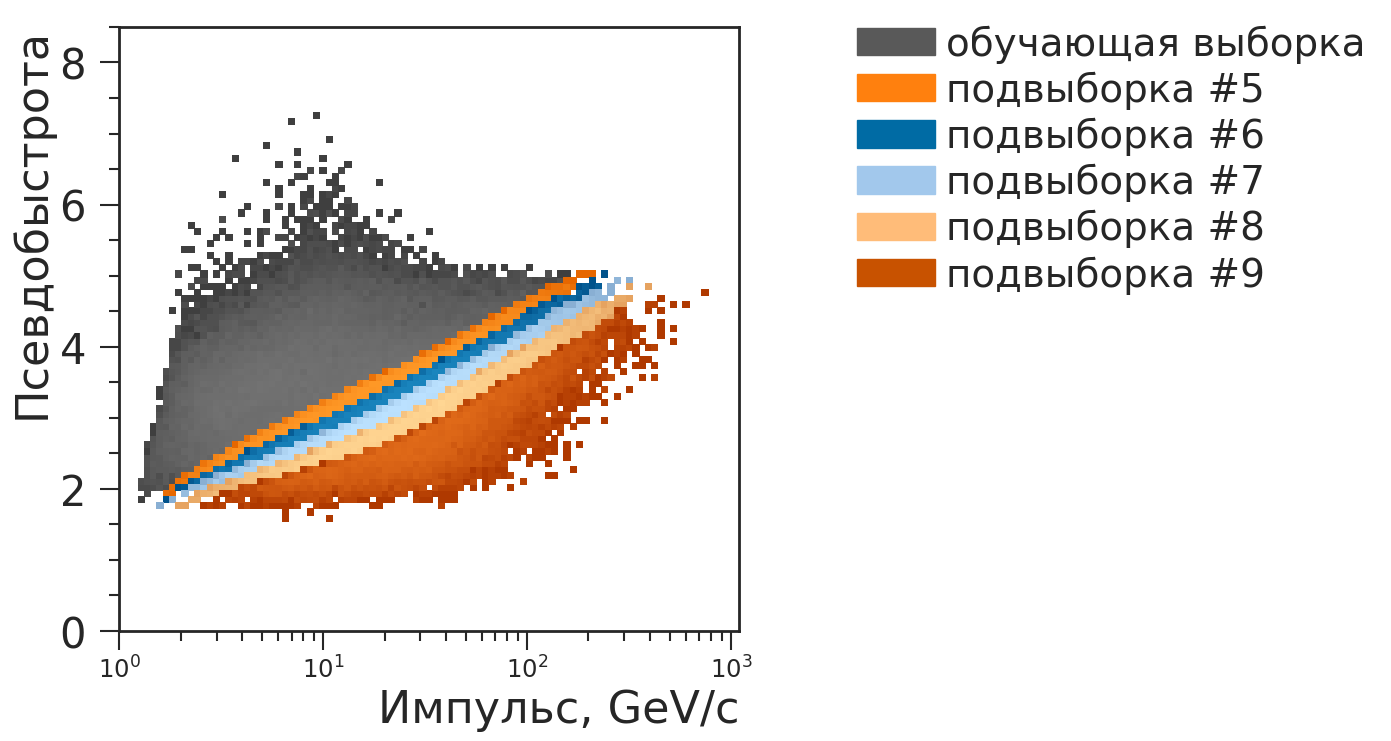

In [468]:
#!g1.1
figure(figsize=(8, 8), dpi=100)
from matplotlib import colors as clrs
from matplotlib.patches import Patch
#sns.set_context("poster", font_scale = 0.7)
#palette = new_clrs
#sns.set(font_scale=1.6)
#sns.set_style("ticks")
bins_x = np.logspace(np.log10(1),np.log10(1100), 100)
bins_y = np.linspace(0, 8.5, num=100)
for i, label in enumerate(['train data', 'test band #5', 'test band #6', 'test band #7', 'test band #8', 'test band #9']):
    d_plot = d[d['labels']==label]
    plt.hist2d(d_plot['Momentum (GeV/c)'], d_plot['Pseudorapidity'], norm=clrs.LogNorm(), bins=[bins_x, bins_y], cmap=newcmps[i])
    

#plt.plot([-2.7, 2.7], [-2.7, 2.7], linewidth=2.0, color='red', linestyle='--', label='train/test split')

plt.style.use('tableau-colorblind10')

#sns.set(font_scale=22)  
#plt.rc('font', **font)
#plt.savefig('line_test.png')

# plt.text(1.2, 0.2, "LHCb Preliminary", horizontalalignment='left', color='black')
#plt.text(550, 5.5, "What if we are \nasked to predict \nhere?", horizontalalignment='right', color='black')
#plt.text(2.5, 2.8, "Available training\ndata", horizontalalignment='left', color='black')
plt.gca().set_xscale('log')
#plt.xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#ml = LogLocator(10)

#plt.axes().xaxis.set_minor_locator(ml)
#plt.xticks([1e0, 1e1, 1e2, 1e3])

plt.xlabel('Импульс, GeV/c', ha='right', x=1)
plt.ylabel('Псевдобыстрота', ha='right', y=1)
plt.minorticks_on()
legend_elements = [
                   Patch(facecolor=colors[i], edgecolor=colors[i],
                         label=labels[i]) for i in range(6)]
plt.legend(handles=legend_elements, loc="lower center", ncol=1, frameon=False, handletextpad=0.3, numpoints=1, labelspacing=0.2, fontsize=28, bbox_to_anchor=(1.6, 0.5))

plt.savefig('log extrapolation illustration.png', format='png', bbox=True, bbox_inches='tight', pad_inches=0.1)

plt.show()

In [473]:
#!g1.1
df = d[~d.index.duplicated()]

In [480]:
#!g1.1
df.iloc[:,:2]

Momentum (GeV/c)  Pseudorapidity
0              9.42628         4.28543
1              2.60346         3.34515
2              7.09840         4.12023
3              8.25125         4.20720
4             16.81370         4.61465
...                ...             ...
9995           3.14700         6.14068
9996           2.40304         5.60435
9997           3.82965         6.67419
9998           2.11837         5.38579
9999           2.18157         5.68847

[10000 rows x 2 columns]

No handles with labels found to put in legend.


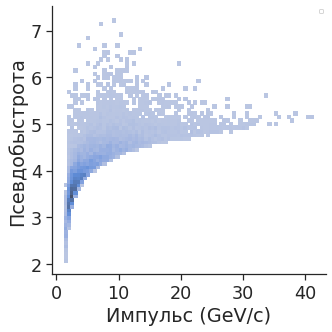

In [494]:
#sns.set(rc={'figure.figsize':(30,30)})

#sns.set_theme(style="whitegrid")
#sns.set_context("poster")
sns.reset_orig()

#sns.set_context("poster", font_scale = 0.7)
palette = new_clrs
sns.set(font_scale=1.6)
sns.set_style("ticks")

df = df.rename(columns={"Momentum (GeV/c)": "Импульс (GeV/c)", "Pseudorapidity": "Псевдобыстрота"})
sns.displot(df, x='Импульс (GeV/c)', y='Псевдобыстрота', palette=palette[:6])

# plt.plot([-2.7, 2.7], [-2.7, 2.7], linewidth=2.0, color='red', linestyle='--', label='train/test split')
plt.legend(fancybox=True, loc='upper right', fontsize=5
          )
font = {'family' : 'normal',
        'size'   : 22}
#sns.set(font_scale=22)  
#plt.rc('font', **font)
#plt.savefig('line_test.png')
# plt.text(100, 7, "LHCb Preliminary", horizontalalignment='left', color='black')
# plt.text(5, 5, "Обучающая\nвыборка", horizontalalignment='left', color='black', weight='semibold')
# plt.text(15, 3, "Что если мы попробуем получить\n предсказание здесь?", horizontalalignment='left',  color='black', weight='bold')
plt.tight_layout()
# plt.savefig('introduction2.png', format='png', dpi=600, bbox_inches='tight', pad_inches=1)

plt.show()

In [ ]:
#!g1.1
